<a href="https://colab.research.google.com/github/Ritikavarshney-hub/MNIST_handwritten_digit_pytorch/blob/main/pytorch_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded=files.upload()

Saving MNIST_ORG.zip to MNIST_ORG.zip


60000 60000 10000 10000


/tmp/ipython-input-20-645192862.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.features=torch.tensor(features,dtype=torch.float32)
/tmp/ipython-input-20-645192862.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels=torch.tensor(labels,dtype=torch.long)


Epoch 1/50, Loss: 0.7349, accuracy:93.17%
Epoch 2/50, Loss: 0.6458, accuracy:96.58%
Epoch 3/50, Loss: 0.6272, accuracy:97.31%
Epoch 4/50, Loss: 0.6151, accuracy:97.81%
Epoch 5/50, Loss: 0.6077, accuracy:98.11%
Epoch 6/50, Loss: 0.6034, accuracy:98.28%
Epoch 7/50, Loss: 0.5971, accuracy:98.53%
Epoch 8/50, Loss: 0.5933, accuracy:98.66%
Epoch 9/50, Loss: 0.5906, accuracy:98.70%
Epoch 10/50, Loss: 0.5879, accuracy:98.85%
Epoch 11/50, Loss: 0.5853, accuracy:98.94%
Epoch 12/50, Loss: 0.5844, accuracy:98.95%
Epoch 13/50, Loss: 0.5816, accuracy:99.02%
Epoch 14/50, Loss: 0.5800, accuracy:99.12%
Epoch 15/50, Loss: 0.5784, accuracy:99.15%
Epoch 16/50, Loss: 0.5776, accuracy:99.15%
Epoch 17/50, Loss: 0.5766, accuracy:99.22%
Epoch 18/50, Loss: 0.5753, accuracy:99.25%
Epoch 19/50, Loss: 0.5739, accuracy:99.27%
Epoch 20/50, Loss: 0.5733, accuracy:99.32%
Epoch 21/50, Loss: 0.5721, accuracy:99.36%
Epoch 22/50, Loss: 0.5719, accuracy:99.40%
Epoch 23/50, Loss: 0.5715, accuracy:99.40%
Epoch 24/50, Loss: 0

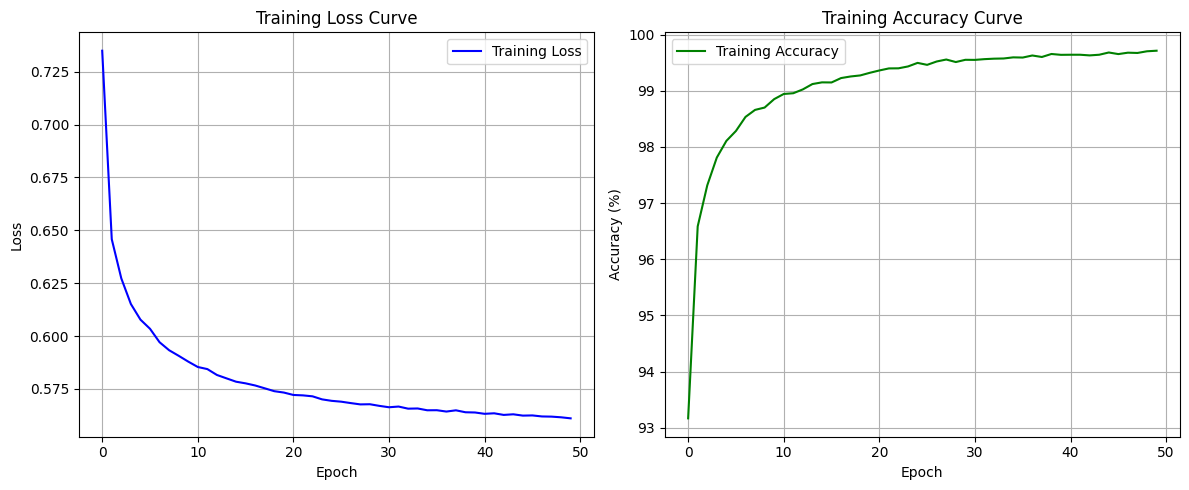

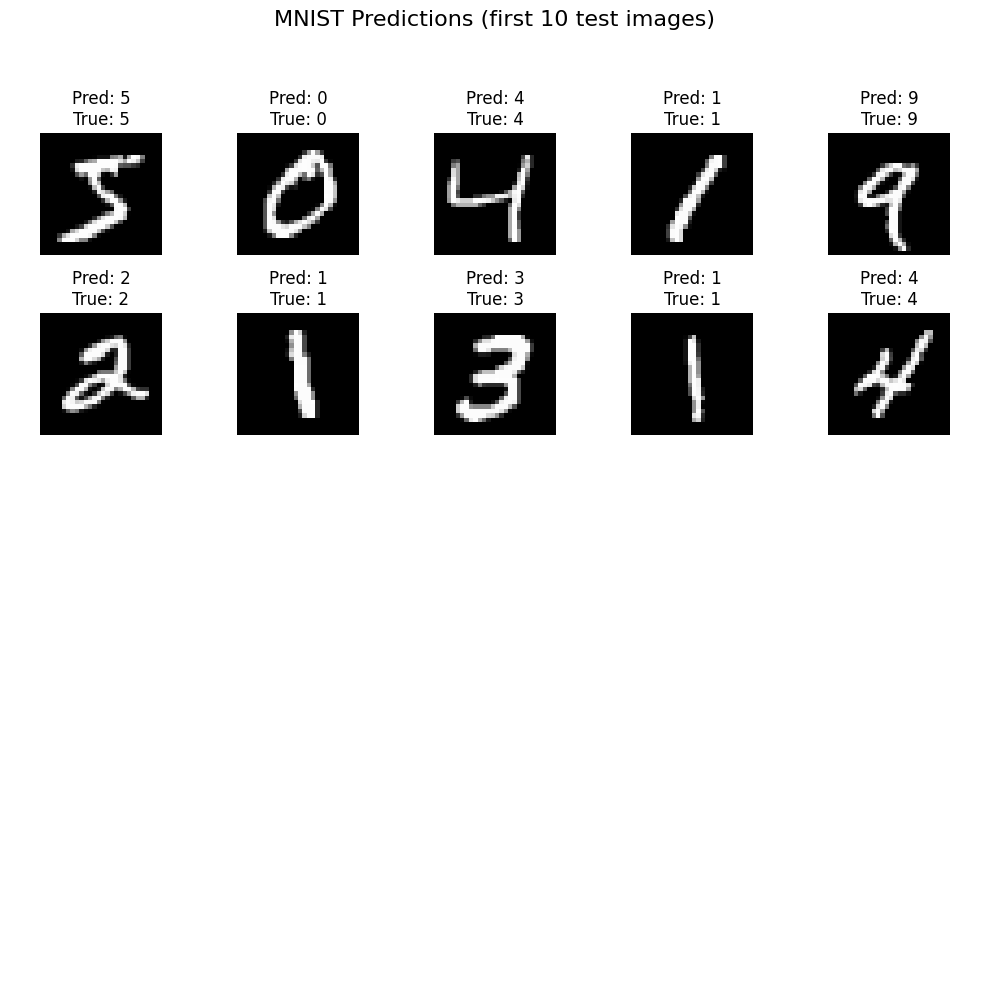

In [ ]:
#importing libraries
!pip install idx2numpy
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import idx2numpy # Import idx2numpy

import zipfile
#extracting file data from zip file
with zipfile.ZipFile("MNIST_ORG.zip",'r') as zip_ref:
  zip_ref.extractall("mnist_data")
import os
os.listdir("mnist_data")
#converting idx datafile into numpy file
images=idx2numpy.convert_from_file("mnist_data/train-images.idx3-ubyte")
labels=idx2numpy.convert_from_file('mnist_data/train-labels.idx1-ubyte')
timages=idx2numpy.convert_from_file('mnist_data/t10k-images.idx3-ubyte')
tlabels=idx2numpy.convert_from_file('mnist_data/t10k-labels.idx1-ubyte')

print(len(images),len(labels),len(timages),len(tlabels))

#convert numpyarray into tensor and scaling features
images = torch.tensor(images / 255.0, dtype=torch.float32).unsqueeze(1)
labels = torch.tensor(labels, dtype=torch.long)
timages=torch.tensor(timages/255.0,dtype=torch.float32).unsqueeze(1)
tlabels=torch.tensor(tlabels,dtype=torch.long)

mean, std = images.mean(), images.std()

# Standardize
images = (images - mean) / std
timages = (timages - mean) / std

torch.manual_seed(42)

device=torch.device('cuda'if torch.cuda.is_available() else 'cpu')

class customdataset(Dataset):
  def __init__(self,features,labels):
    self.features=torch.tensor(features,dtype=torch.float32)
    self.labels=torch.tensor(labels,dtype=torch.long)
  def __getitem__(self,index):
    return self.features[index],self.labels[index]
  def __len__(self):
    return len(self.features)

traindataset=customdataset(images,labels)
testdataset=customdataset(timages,tlabels)

trainloader=DataLoader(traindataset,batch_size=128,shuffle=True ,pin_memory=True)
testloader=DataLoader(testdataset,batch_size=128,shuffle=False, pin_memory=True)

class one_layer_nn(nn.Module):
  def __init__(self ,num_features):
    super().__init__()
    self.flatten=nn.Flatten()
    self.linear_relu_stack=nn.Sequential(
        nn.Linear(num_features,256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(256,10)
    )
  def forward(self,x):
    x = self.flatten(x)
    return self.linear_relu_stack(x)

learning_rate=0.001
epoches=50
model=one_layer_nn(images.shape[2]*images.shape[3])
model=model.to(device)
loss_fn=nn.CrossEntropyLoss(label_smoothing= 0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate , weight_decay=1e-5)

train_losses = []
train_accuracies = []

for epoch in range(epoches):
  total_epoch_loss=0
  correct=0
  total=0
  for batch_features,batch_labels in trainloader:
    batch_features,batch_labels=batch_features.to(device),batch_labels.to(device)
    pred=model(batch_features)
    loss=loss_fn(pred,batch_labels)
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    total_epoch_loss+=loss.item()
    _, predicted = pred.max(1)
    correct += (predicted == batch_labels).sum().item()
    total += batch_labels.size(0)
  acc=100.*correct/total
  avg_epoch_loss=total_epoch_loss/len(trainloader)
  train_losses.append(avg_epoch_loss)
  train_accuracies.append(acc)
  print(f"Epoch {epoch+1}/{epoches}, Loss: {avg_epoch_loss:.4f}, accuracy:{acc:.2f}%")

model.eval()

tcorrect=0
ttotal=0
tloss=0
simages, slabels = next(iter(testloader))
simages, slabels = images[:10], labels[:10]
simages = simages.to(device)
with torch.no_grad():
  for batch_features,batch_labels in testloader:
    batch_features,batch_labels=batch_features.to(device),batch_labels.to(device)
    ouput=model(batch_features)
    loss=loss_fn(ouput,batch_labels)
    _,predicted=ouput.max(1)
    tloss+=loss.item()
    tcorrect+=(predicted==batch_labels).sum().item()
    ttotal+=batch_labels.size(0)
avg_test_loss=tloss/len(testloader)
tacc=100.*tcorrect/ttotal

print(f"Test loss : {avg_test_loss:.4f}, Accuracy: {tacc:.2f}%")

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss", color='blue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy", color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy Curve")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

model.eval()
with torch.no_grad():
    soutputs = model(simages)
    _, spreds = soutputs.max(1)

simages = simages.cpu()
spreds = spreds.cpu()
slabels = slabels.cpu()

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
fig.suptitle('MNIST Predictions (first 10 test images)', fontsize=16)

for i in range(25):
    ax = axes[i // 5, i % 5]
    ax.axis('off')

    if i < 10:
        img = simages[i].squeeze(0)
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Pred: {spreds[i]}\nTrue: {slabels[i]}")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()




60000 60000 10000 10000
Epoch 1/20, Loss: 0.2144, accuracy:93.67%
Epoch 2/20, Loss: 0.1037, accuracy:96.81%
Epoch 3/20, Loss: 0.0778, accuracy:97.51%
Epoch 4/20, Loss: 0.0676, accuracy:97.81%
Epoch 5/20, Loss: 0.0563, accuracy:98.19%
Epoch 6/20, Loss: 0.0494, accuracy:98.36%
Epoch 7/20, Loss: 0.0433, accuracy:98.58%
Epoch 8/20, Loss: 0.0375, accuracy:98.76%
Epoch 9/20, Loss: 0.0349, accuracy:98.80%
Epoch 10/20, Loss: 0.0318, accuracy:98.94%
Epoch 11/20, Loss: 0.0281, accuracy:99.06%
Epoch 12/20, Loss: 0.0282, accuracy:99.06%
Epoch 13/20, Loss: 0.0277, accuracy:99.09%
Epoch 14/20, Loss: 0.0208, accuracy:99.25%
Epoch 15/20, Loss: 0.0236, accuracy:99.22%
Epoch 16/20, Loss: 0.0223, accuracy:99.24%
Epoch 17/20, Loss: 0.0186, accuracy:99.36%
Epoch 18/20, Loss: 0.0211, accuracy:99.31%
Epoch 19/20, Loss: 0.0177, accuracy:99.39%
Epoch 20/20, Loss: 0.0181, accuracy:99.40%
Test loss : 0.0588, Accuracy: 98.43%


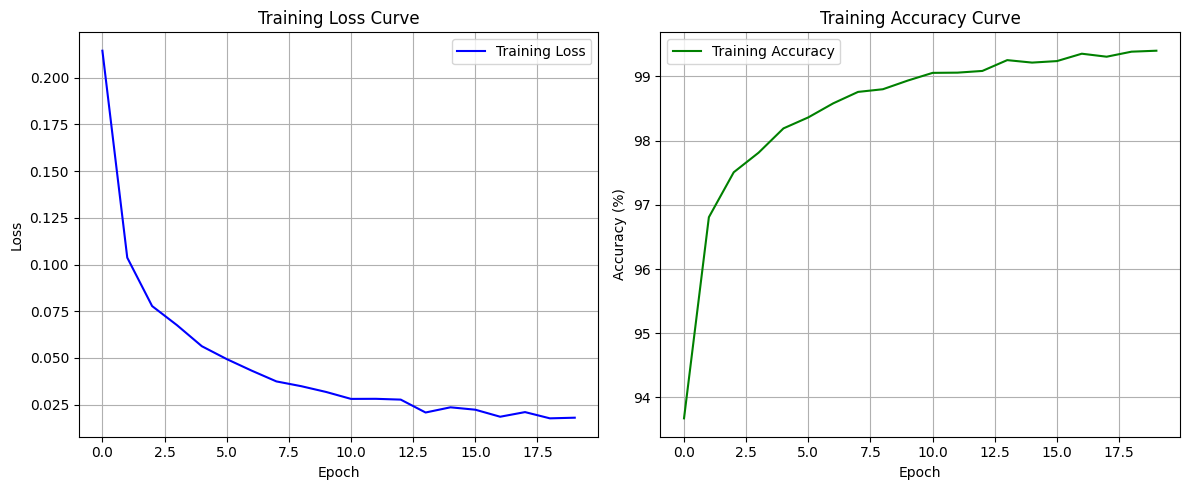

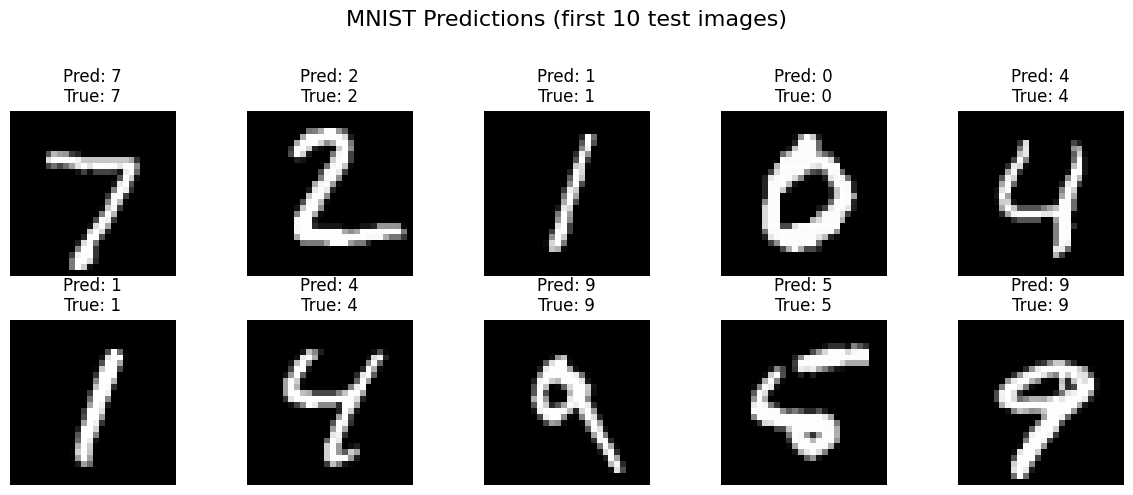

In [ ]:
#importing libraries
!pip install idx2numpy
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import idx2numpy # Import idx2numpy

import zipfile
#extracting file data from zip file
with zipfile.ZipFile("MNIST_ORG.zip",'r') as zip_ref:
  zip_ref.extractall("mnist_data")
import os
os.listdir("mnist_data")
#converting idx datafile into numpy file
images=idx2numpy.convert_from_file("mnist_data/train-images.idx3-ubyte")
labels=idx2numpy.convert_from_file('mnist_data/train-labels.idx1-ubyte')
timages=idx2numpy.convert_from_file('mnist_data/t10k-images.idx3-ubyte')
tlabels=idx2numpy.convert_from_file('mnist_data/t10k-labels.idx1-ubyte')

print(len(images),len(labels),len(timages),len(tlabels))

#convert numpyarray into tensor and scaling features
images = torch.tensor(images / 255.0, dtype=torch.float32).unsqueeze(1)
labels = torch.tensor(labels, dtype=torch.long)
timages=torch.tensor(timages/255.0,dtype=torch.float32).unsqueeze(1)
tlabels=torch.tensor(tlabels,dtype=torch.long)

mean,std=images.mean(),images.std()

# Standardize
images = (images - mean) / std
timages = (timages - mean) / std

torch.manual_seed(42)

device=torch.device('cuda'if torch.cuda.is_available() else 'cpu')

class customdataset(Dataset):
  def __init__(self,features,labels):
    # Features are already tensors from the conversion above, avoid re-converting
    self.features=features
    self.labels=labels
  def __getitem__(self,index):
    return self.features[index],self.labels[index]
  def __len__(self):
    return len(self.features)

traindataset=customdataset(images,labels)
testdataset=customdataset(timages,tlabels)

trainloader=DataLoader(traindataset,batch_size=64,shuffle=True ,pin_memory=True)
testloader=DataLoader(testdataset,batch_size=64,shuffle=False, pin_memory=True)

# Two-layer NN
class two_layer_nn(nn.Module):
  def __init__(self ,num_features):
    super().__init__()
    self.flatten=nn.Flatten()
    self.linear_relu_stack=nn.Sequential(
        nn.Linear(num_features,512),  # First hidden layer
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(512,256), # Second hidden layer
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(256,10)
    )
  def forward(self,x):
    x = self.flatten(x)
    return self.linear_relu_stack(x)

learning_rate=0.001
epoches=20


model=two_layer_nn(images.shape[2]*images.shape[3]) # Corrected input features
model=model.to(device)
loss_fn=nn.CrossEntropyLoss()
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate , weight_decay=1e-6)

train_losses = []
train_accuracies = []

for epoch in range(epoches):
  total_epoch_loss=0
  correct=0
  total=0
  for batch_features,batch_labels in trainloader:
    batch_features,batch_labels=batch_features.to(device),batch_labels.to(device)
    pred=model(batch_features)
    loss=loss_fn(pred,batch_labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_epoch_loss+=loss.item()
    _, predicted = pred.max(1)
    correct += (predicted == batch_labels).sum().item()
    total += batch_labels.size(0)
  acc=100.*correct/total
  avg_epoch_loss=total_epoch_loss/len(trainloader)
  train_losses.append(avg_epoch_loss)
  train_accuracies.append(acc)
  print(f"Epoch {epoch+1}/{epoches}, Loss: {avg_epoch_loss:.4f}, accuracy:{acc:.2f}%")

model.eval()

tcorrect=0
ttotal=0
tloss=0
# Get a batch of images for visualization from the test set
simages_vis, slabels_vis = next(iter(testloader))
# Take the first 10 images from this batch for visualization
simages_vis = simages_vis[:10]
slabels_vis = slabels_vis[:10]
simages_vis = simages_vis.to(device)


with torch.no_grad():
  for batch_features,batch_labels in testloader:
    batch_features,batch_labels=batch_features.to(device),batch_labels.to(device)
    ouput=model(batch_features)
    loss=loss_fn(ouput,batch_labels)
    _,predicted=ouput.max(1)
    tloss+=loss.item()
    tcorrect+=(predicted==batch_labels).sum().item()
    ttotal+=batch_labels.size(0)
avg_test_loss=tloss/len(testloader)
tacc=100.*tcorrect/ttotal

print(f"Test loss : {avg_test_loss:.4f}, Accuracy: {tacc:.2f}%")

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss", color='blue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy", color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy Curve")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

model.eval()
with torch.no_grad():
    soutputs = model(simages_vis) # Use simages_vis here
    _, spreds = soutputs.max(1)

simages_vis = simages_vis.cpu()
spreds = spreds.cpu()
slabels_vis = slabels_vis.cpu()

fig, axes = plt.subplots(2, 5, figsize=(12, 5)) # Adjusted for 10 images
fig.suptitle('MNIST Predictions (first 10 test images)', fontsize=16)

for i in range(10): # Loop through 10 images
    ax = axes[i // 5, i % 5]
    ax.axis('off')

    img = simages_vis[i].squeeze(0)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Pred: {spreds[i].item()}\nTrue: {slabels_vis[i].item()}") # .item() for scalar tensors

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()